In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import torch
import transformers
import wandb

from dataloader import DataLoader
from evaluate import load
from trainer import CustomTrainer
from transformers import (
    AutoModelForSequenceClassification,
    TrainingArguments,
    DataCollatorWithPadding
)
from datasets import load_dataset

/vol/bitbucket/hrm20/dlenv2/lib/python3.12/site-packages/transformers/utils/hub.py:128: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [2]:
torch.cuda.empty_cache()

# Load Dataset

In [3]:
# os.environ["WANDB_MODE"] = "disabled"  # Disable wandb logging
# os.environ["WANDB_DISABLED"] = "true"  # Fully disable wandb

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model_name = "prajjwal1/bert-tiny"
dataset_name = "multi_nli"

data_loader = DataLoader(dataset_name, model_name)
train_dataset, eval_dataset, tokenizer, num_labels = data_loader.prepare_datasets()

Using device: cuda


# Train

In [4]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels  # MNLI has 3 classes: entailment, contradiction, neutral
)
model.to(device)

# Load accuracy metric
metric = load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

# Training arguments
training_args = TrainingArguments(
    output_dir="bert-tiny-mnli",
    # learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    # weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
    logging_steps=500,
    logging_first_step=True,
)


wandb.init(
    project="bert_tiny_mnli",
    name=f"{training_args.num_train_epochs}_epochs_{dataset_name}_bert_tiny",
    config=training_args.to_dict(),
)

# Initialise trainer and train
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
    methods=["loss", "forgetting"]
)

trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/vol/bitbucket/hrm20/dlenv2/lib/python3.12/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: Currently logged in as: hugomilosz (hugomilosz-imperial-college-london) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


/vol/bitbucket/hrm20/fyp/trainer.py:9: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.787700,0.746232,0.675497
2,0.745700,0.713441,0.693123
3,0.698700,0.697572,0.701885
4,0.675000,0.696219,0.706266


TrainOutput(global_step=98176, training_loss=0.7455133321200834, metrics={'train_runtime': 1173.8621, 'train_samples_per_second': 1338.154, 'train_steps_per_second': 83.635, 'total_flos': 499078424672256.0, 'train_loss': 0.7455133321200834, 'epoch': 4.0})

# Analysis

## Forgetting

In [24]:
forgetting_results = trainer.get_unified_stats()['forgetting_stats']['forgetting_events']
forgetting_results

{0: 1,
 1: 1,
 2: 0,
 3: 0,
 4: 0,
 5: 1,
 6: 0,
 7: 1,
 8: 1,
 9: 1,
 10: 1,
 11: 1,
 12: 0,
 13: 1,
 14: 0,
 15: 1,
 16: 0,
 17: 1,
 18: 0,
 19: 1,
 20: 1,
 21: 0,
 22: 1,
 23: 1,
 24: 0,
 25: 1,
 26: 1,
 27: 1,
 28: 1,
 29: 1,
 30: 1,
 31: 0,
 32: 1,
 33: 1,
 34: 1,
 35: 1,
 36: 0,
 37: 0,
 38: 1,
 39: -1,
 40: 1,
 41: 1,
 42: 0,
 43: 1,
 44: -1,
 45: 1,
 46: 0,
 47: 0,
 48: 0,
 49: 1,
 50: 0,
 51: 1,
 52: 1,
 53: 0,
 54: 1,
 55: 0,
 56: 1,
 57: 1,
 58: 1,
 59: 1,
 60: 1,
 61: 1,
 62: 0,
 63: 0,
 64: 0,
 65: 1,
 66: 1,
 67: 1,
 68: 1,
 69: 0,
 70: 1,
 71: 0,
 72: 2,
 73: 1,
 74: 0,
 75: 1,
 76: 0,
 77: 1,
 78: 1,
 79: 1,
 80: 0,
 81: 0,
 82: 0,
 83: 0,
 84: 0,
 85: 0,
 86: 0,
 87: 0,
 88: 0,
 89: 1,
 90: 0,
 91: 0,
 92: 0,
 93: 0,
 94: 1,
 95: 1,
 96: 0,
 97: 0,
 98: 0,
 99: 0,
 100: 1,
 101: 1,
 102: 1,
 103: 1,
 104: 0,
 105: 1,
 106: 1,
 107: 0,
 108: 1,
 109: 1,
 110: 0,
 111: 0,
 112: 0,
 113: 1,
 114: 1,
 115: 1,
 116: 1,
 117: 1,
 118: 1,
 119: 0,
 120: 0,
 121: 1,
 122: 1,
 

In [25]:
loss = trainer.get_unified_stats()['loss_stats']['epoch_losses']
epoch_losses = loss

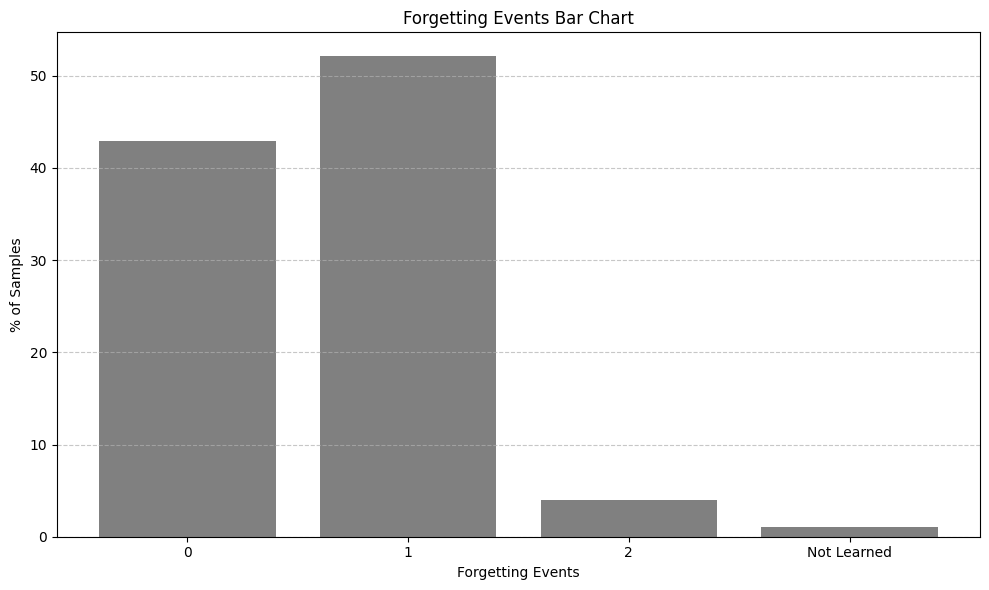

In [26]:
# Count freqs of forgetting events
forgetting_counts = {}
for value in forgetting_results.values():
    if value not in forgetting_counts:
        forgetting_counts[value] = 0
    forgetting_counts[value] += 1

# Separate not-learned from other labels
forgetting_keys = sorted([k for k in forgetting_counts.keys() if k != -1])
forgetting_labels = forgetting_keys + ["Not Learned"]

total_samples = len(train_dataset)

# Calculate percentages
forgetting_values = [forgetting_counts[k] / total_samples * 100 for k in forgetting_keys]
forgetting_values.append(forgetting_counts[-1] / total_samples * 100)

# Plot chart
plt.figure(figsize=(10, 6))
plt.bar(range(len(forgetting_labels)), forgetting_values, color='gray')

plt.xticks(range(len(forgetting_labels)), forgetting_labels)
plt.xlabel("Forgetting Events")
plt.ylabel("% of Samples")
plt.title("Forgetting Events Bar Chart")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.savefig("forgetting_events.png")
wandb.log({"Forgetting Events Chart": wandb.Image("forgetting_events.png")})

plt.tight_layout()
plt.show()


In [27]:
print(forgetting_counts)

{1: 204559, 0: 168486, -1: 4216, 2: 15441}


## Losses

In [28]:
per_sample_losses = trainer.get_unified_stats()['loss_stats']['per_sample_losses']
per_sample_losses

{0: [0.2821345925331116,
  0.2123579978942871,
  0.8116576671600342,
  0.7597669363021851],
 1: [1.5386614799499512,
  0.10928507894277573,
  0.6603083610534668,
  0.09625887125730515],
 2: [1.514723539352417,
  2.0834298133850098,
  0.8551056385040283,
  0.4518134891986847],
 3: [1.0449211597442627,
  1.2416601181030273,
  1.3446171283721924,
  0.3270701467990875],
 4: [0.4599633812904358,
  0.9416415095329285,
  0.040021006017923355,
  0.05625004321336746],
 5: [0.8487446904182434,
  0.591987133026123,
  0.9862897396087646,
  0.21518386900424957],
 6: [2.0476837158203125,
  1.9990534782409668,
  1.857475757598877,
  0.08661925047636032],
 7: [0.5231256484985352,
  0.029255613684654236,
  0.8434218764305115,
  0.6869972348213196],
 8: [1.2984280586242676,
  0.08912746608257294,
  0.21018970012664795,
  1.123819351196289],
 9: [0.7287601828575134,
  1.3927674293518066,
  0.11017777770757675,
  0.05355280637741089],
 10: [0.3104671537876129,
  2.773122787475586,
  0.28326234221458435,
 

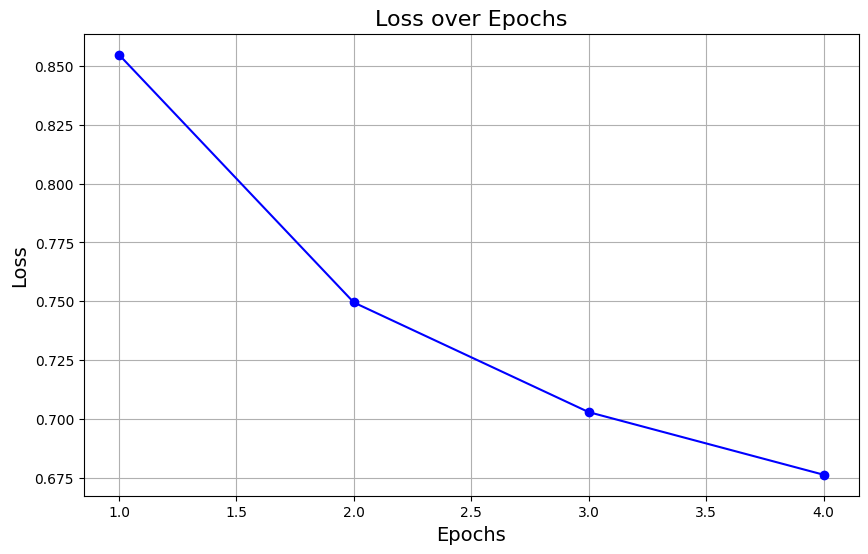

[0.854855988619089, 0.7494911403605299, 0.7028650555212046, 0.6762420034893294]


In [29]:
# Plot the average loss per epoch
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, marker='o', linestyle='-', color='b')

plt.title("Loss over Epochs", fontsize=16)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.grid(True)

plt.savefig("loss_over_epochs.png")
wandb.log({"Loss over Epochs": wandb.Image("loss_over_epochs.png")})
plt.show()
print(epoch_losses)

In [30]:
# Define negation words
negation_words = {"not", "no", "never", "none", "nothing", "nowhere", "neither", "nor",
                  "can't", "won't", "doesn't", "isn't", "aren't", "wasn't", "weren't",
                  "haven't", "hasn't", "hadn't", "wouldn't", "shouldn't", "mustn't"}

# Function to check if a sentence contains negation words
def contains_negation(sentence):
    words = set(sentence.lower().split())
    return any(word in negation_words for word in words)

# Function to compute token-level overlap between hypothesis and premise
def compute_overlap(premise, hypothesis):
    premise_tokens = set(premise.lower().split())
    hypothesis_tokens = hypothesis.lower().split()
    if not hypothesis_tokens:
        return 0
    overlap_ratio = sum(1 for token in hypothesis_tokens if token in premise_tokens) / len(hypothesis_tokens)
    return overlap_ratio

# Initialize counters for train and validation
results = {
    "train": {
        "Contradiction with Negation": 0,
        "Contradiction without Negation": 0,
        "Entailment with High Word Overlap": 0,
        "Entailment with Low Word Overlap": 0,
        "Entailment with Negation": 0,
        "Entailment without Negation": 0,
        "Contradiction with High Word Overlap": 0,
        "Contradiction with Low Word Overlap": 0,
    },
    "validation_matched": {
        "Contradiction with Negation": 0,
        "Contradiction without Negation": 0,
        "Entailment with High Word Overlap": 0,
        "Entailment with Low Word Overlap": 0,
        "Entailment with Negation": 0,
        "Entailment without Negation": 0,
        "Contradiction with High Word Overlap": 0,
        "Contradiction with Low Word Overlap": 0,
    },
}

## Example Groups

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset

# Load the MNLI dataset from Hugging Face
mnli = load_dataset('multi_nli')

# Define negation words
negation_words = {"not", "no", "never", "none", "nothing", "nowhere", "neither", "nor",
                  "can't", "won't", "doesn't", "isn't", "aren't", "wasn't", "weren't",
                  "haven't", "hasn't", "hadn't", "wouldn't", "shouldn't", "mustn't"}

# Function to check if a sentence contains negation words
def contains_negation(sentence):
    words = set(sentence.lower().split())
    return any(word in negation_words for word in words)

# Function to compute token-level overlap between hypothesis and premise
def compute_overlap(premise, hypothesis):
    premise_tokens = set(premise.lower().split())
    hypothesis_tokens = hypothesis.lower().split()
    if not hypothesis_tokens:
        return 0
    overlap_ratio = sum(1 for token in hypothesis_tokens if token in premise_tokens) / len(hypothesis_tokens)
    return overlap_ratio

# Initialise data structures to store results
results = {
    "Contradiction with High Word Overlap": [],
    "Entailment with High Word Overlap": [],
}

# Filter indices for each group
for idx, example in enumerate(mnli["train"]):
    premise = example["premise"]
    hypothesis = example["hypothesis"]
    label = example["label"]

    overlap_ratio = compute_overlap(premise, hypothesis)
    high_overlap = overlap_ratio >= 0.8  # Threshold set to 80%

    if label == 2 and high_overlap:  # Contradiction with High Word Overlap
        results["Contradiction with High Word Overlap"].append(idx)
    elif label == 0 and high_overlap:  # Entailment with High Word Overlap
        results["Entailment with High Word Overlap"].append(idx)

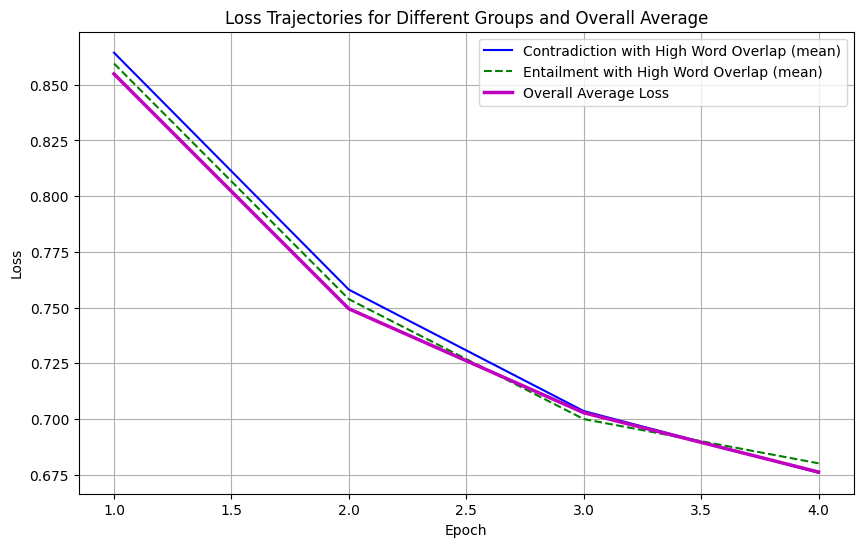

In [ ]:

# Plot losses for all groups and overall average
plt.figure(figsize=(10, 6))

line_styles = ['-', '--', '-.']
colors = ['b', 'g', 'r']

# Get the overall epoch losses
epoch_losses = trainer.get_unified_stats()['loss_stats']['epoch_losses']

# Loop through each group and plot its loss trajectory
for idx, (group, indices) in enumerate(results.items()):
    if not indices:
        print(f"No examples in the group {group}.")
        continue
        
    # Collect losses for the group
    group_losses = [per_sample_losses[idx] for idx in indices if idx in per_sample_losses]
    max_epochs = max(len(losses) for losses in group_losses)
    
    # Pad shorter sequences with NaN
    padded_group_losses = [
        losses + [np.nan] * (max_epochs - len(losses)) if len(losses) < max_epochs else losses
        for losses in group_losses
    ]
    group_losses_array = np.array(padded_group_losses)
    
    # Calculate average loss per epoch across all examples in the group
    avg_loss_per_epoch = np.nanmean(group_losses_array, axis=0)
    std_loss_per_epoch = np.nanstd(group_losses_array, axis=0)
    
    epochs = range(1, len(avg_loss_per_epoch) + 1)
    
    # Plot loss of groups
    plt.plot(epochs, avg_loss_per_epoch, 
             label=f"{group} (mean)", 
             linestyle=line_styles[idx % len(line_styles)], 
             color=colors[idx % len(colors)])

# Plot overall average loss
epochs_overall = range(1, len(epoch_losses) + 1)
plt.plot(epochs_overall, epoch_losses, 
         label='Overall Average Loss', 
         linestyle='-', 
         color=colors[-1], 
         linewidth=2.5)

plt.title("Loss Trajectories for Different Groups and Overall Average")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

In [33]:
plt.savefig("group_loss_trajectories.png")
wandb.log({"Loss Trajectories for High Word Overlap Groups": wandb.Image("group_loss_trajectories.png")})

<Figure size 640x480 with 0 Axes>

In [ ]:
wandb.log({
    "epoch_losses": epoch_losses,
    "per_sample_losses": per_sample_losses,
    "final_forgetting_stats": forgetting_results,
})

In [ ]:
 wandb.finish()